# imports

In [1]:
import os
import matplotlib.pyplot as plt
import numpy as np
import gstools as gs
from torch.utils.data import Dataset, DataLoader
import torch
from multiprocessing import Pool, cpu_count
from functools import partial
import time
from timeit import timeit
from pathlib import Path
from phiml.backend import set_global_default_backend, set_global_precision
import phiml.math as pmath
# from phi.jax.flow import Box, CenteredGrid, extrapolation, diffuse, concat, tensor, spatial, plot, wrap, Field, batch, iterate, Solve, StaggeredGrid, stack, expand, Shape
from tqdm.notebook import trange
import phi.flow as flow
set_global_default_backend("torch")
# set_global_default_backend("numpy")
set_global_precision(64)
import pyreact
from pyreact.dataloader import DefaultDataset
from pyreact.diffusion import Diffusionsolver, diffusivity_model
from pyreact.random_fields import generate_fields

/home/jlux/miniforge3/envs/AI/lib/python3.12/site-packages/torch/cuda/__init__.py:654: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")


# Random fields generation
## Parameters

In [2]:
gridsize = 128
x = y = np.arange(gridsize) / (gridsize - 1) # normalize [0-1]
grid_pos = [x, y]

# GRF params. The grid is 1 x 1 unit
init_len_scale = 0.1
min_len_scale = 0.05
max_len_scale = 0.2
base_var = 1

# porosity and diffusivity params. See geocorail report
avg_p = 16.6 / 100. # inter-granular porosity
std = 2.7 / 100.    # measured std
trunc = 3      # we truncate at 3 sigma
min_p = avg_p - trunc * std
max_p = avg_p + trunc * std


## Generation

In [3]:
nsamples = 100
base_folder = Path("/home/jlux/ownCloud/DATA/REACTDIFF/DFIELDS/128x128")
now = time.strftime("%Y-%m-%d_%H-%M-%S")
generate_fields(
    nsamples,
    grid_pos=grid_pos,
    porosity_avg=avg_p,
    porosity_std=std,
    min_ls=min_len_scale,
    max_ls=max_len_scale,
    folder=os.path.join(base_folder, now),
    trunc=trunc,
)

Creating 100 fields with min_p: 0.08, max_p: 0.25


Generated 100 fields in 10.47 seconds, 9.55 fields/s


## Visualization

<Figure size 640x480 with 0 Axes>

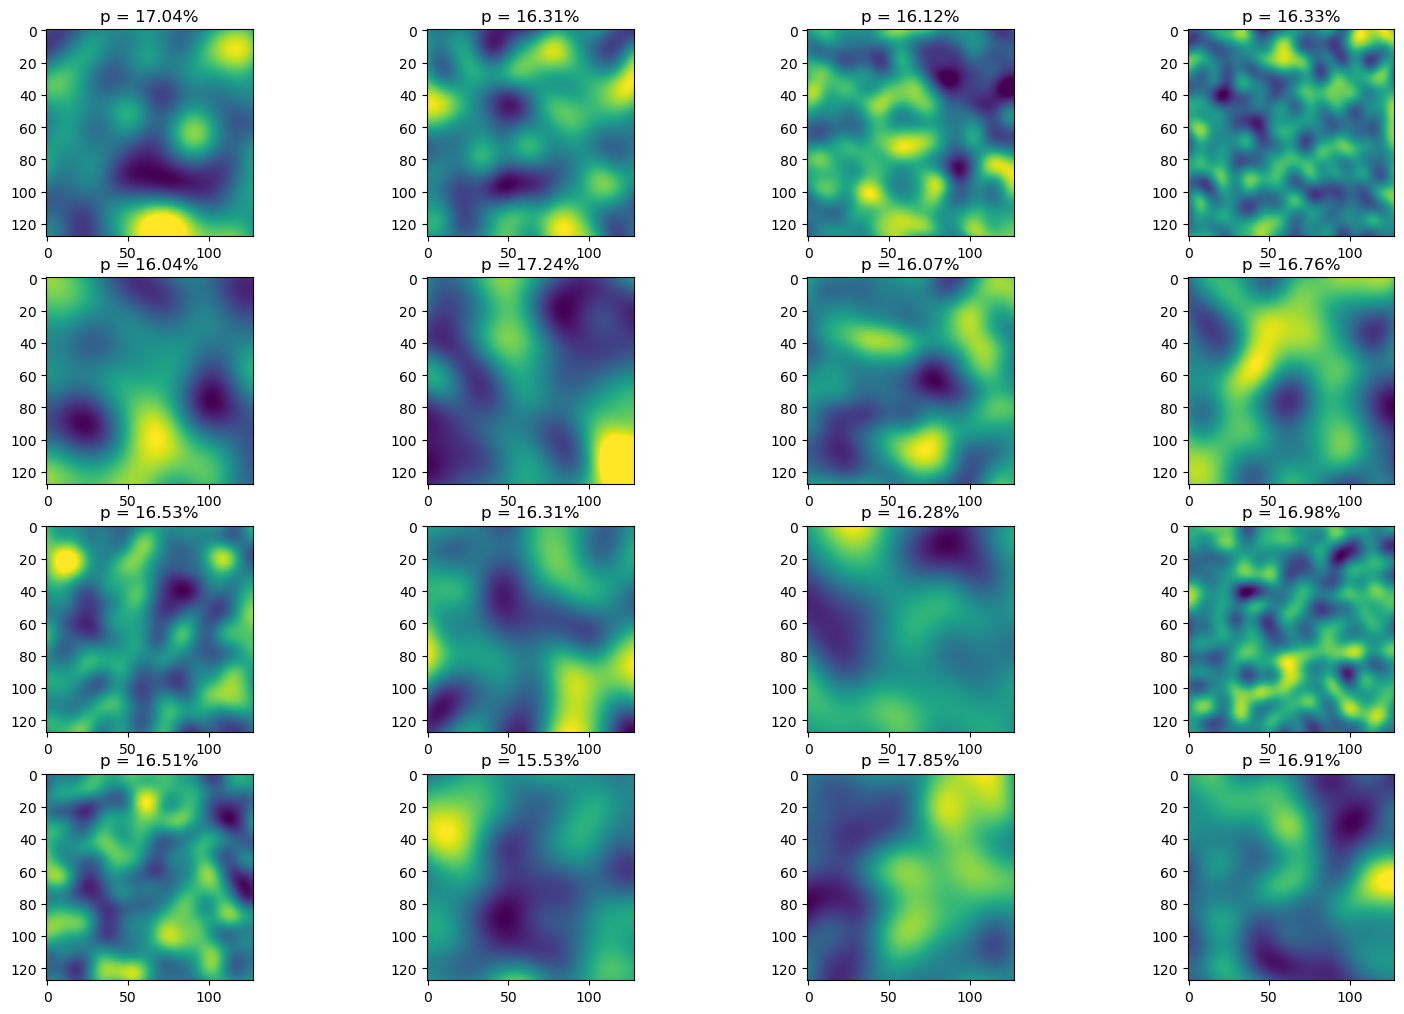

In [13]:
npick = 16
ncols = 4
nrows = nsamples // ncols + (nsamples % ncols > 0)
plt.clf()
plt.figure(figsize=(18, 20 * npick // ncols))
plt.subplots_adjust(wspace=0.5)
# fig, ax = pt.subplots(ncols, nrows, sharex=True, sharey=True)
# ax = ax.flatten()
folder = Path(f"/home/jlux/ownCloud/DATA/REACTDIFF/DFIELDS/128x128/{now}/PORO")
for i in range(npick):
    p = np.load(os.path.join(folder, f"porosity_{i:04d}.npy"))
    ax = plt.subplot(nrows, ncols, i + 1)
    ax.imshow(p.T)
    ax.set_title(f"p = {p.mean()*100:.2f}%")
plt.show()

# Numerical simulations

# Creating a dataloader
The random porosity fields aretransformed into diffusivity using the provided diffusivity model which takes the form of a power law:
$$
D = D_0 \phi^n
$$
where $D$ is the bulk diffusivity (depedns only on T) and $n$ is a parameter that controls the non-linearity of the diffusivity-porosity relationship. 

**Note for adimensionalization:**  

Diffusivity for Mg2+ = 0.705e-9 m²/s  
Typical Mg2+ concentration in seawater 0.05 mol/kg  
To adimensionalize the equation we can use:
- $c_{ref} = 0.05 mol/kg$
- $D_{ref} = 0.705e-9 m²/s$
- $t_{ref} = L² / D_{ref} $ or $t_{ref} = L² / <D>$  
where $<D>$ is the average diffusivity of the field and $L$ the length of the domain.

The diffusion is solved in parallel for a batch of porosity fields. The batch size should be higher as possible to decrease the computational time.

In [49]:
base_folder = Path("/home/jlux/ownCloud/DATA/REACTDIFF/DFIELDS/2025-05-16_11-50-31/PORO")
dinf = 0.705e-9 # m²/s
transform = partial(diffusivity_model, d0=dinf, exponent=1.5)
dataset = DefaultDataset(base_folder, transform=transform, file_pattern="*.npy")
batch_size = 100
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=False, num_workers=cpu_count() // 2, pin_memory=True)

## Solver initialization

In [52]:
bc = {'x-': 1, 'x+': 0, 'y': flow.extrapolation.PERIODIC}
h = 50e-6 # grid step m
solver = Diffusionsolver(bc=bc, h=h, solver=flow.Solve('CG', abs_tol=1e-8, rel_tol=1e-8), implicit=False, usefloat64=True)
now = time.strftime("%Y-%m-%d_%H-%M-%S")
savefolder = Path(f"/home/jlux/ownCloud/DATA/REACTDIFF/DFIELDS/128x128/results/{now}")
CFL = 0.25*h**2/dataset[0].mean()
t_steady = CFL * np.max(dataset[0].shape[1:])**2
dt = CFL
print(f"average diffusivity in first image {dataset[0].mean():.2e} m²/s")
print(f"Size of the domain {h*dataset[0].shape[0]:.2e} * {h*dataset[0].shape[1]:.2e} m²")
print(f"Area of the grid element {h**2*1e6:.2e} mm²")
print(f"CFL time step {CFL:4.2f}s")
print(f"Estimated steady state time {t_steady:4.2e}s or {t_steady/60:4.2e} min or {t_steady/3600:4.2f} h or {t_steady/(3600*24):4.2f} d")
print(f"Number of time step needed: {int(t_steady/dt)}")

average diffusivity in first image 1.42e-11 m²/s
Size of the domain 1.28e-02 * 1.28e-02 m²
Area of the grid element 2.50e-03 mm²
CFL time step 43.86s
Estimated steady state time 2.87e+06s or 4.79e+04 min or 798.48 h or 33.27 d
Number of time step needed: 65536


## Run simulations

In [53]:
# if keep_results is True, the results are stored in the results attribute of the solver object
# Beware that this will consume a lot of memory if the number of simulations is large
# if folder is not none, the results are saved in the folder as npy files (one file per simulations, with all the time steps)
solver.run(dataloader, dt=dt, iterations=1280, batch_to_process=None, keep_results=True, folder=savefolder)

  0%|          | 0/1280 [00:00<?, ?it/s]/home/jlux/miniforge3/envs/AI/lib/python3.12/site-packages/pyreact/diffusion.py:41: RuntimeWarning: CFL condition violated (CFL = 0.5 > 0.5) in diffuse.explicit() with diffusivity=Field[(idᵇ=50, xˢ=256, yˢ=256)], dt=43.86172866821289, dx=(x=0.000, y=0.000). Increase substeps or use diffuse.implicit() instead.
  c = flow.diffuse.explicit(c, diffusivity=D, dt=dt)
 20%|█▉        | 252/1280 [02:52<11:42,  1.46it/s]


KeyboardInterrupt: 

In [34]:
solver.results

Field[(timeᵇ=129, idᵇ=4, xˢ=256, yˢ=256)]

In [35]:
flow.plot(solver.results.time[::4].id[:4], animate='time')

<Figure size 640x480 with 0 Axes>